# Sparse Gaussian Process 

In [1]:
import matplotlib as mpl; mpl.use('pgf')

In [2]:
%matplotlib inline

In [3]:
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from collections import defaultdict

from matplotlib import animation
from IPython.display import HTML
from etudes.gaussian_processes import gp_sample_custom, dataframe_from_gp_samples

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
golden_ratio = 0.5 * (1 + np.sqrt(5))
golden_size = lambda width: (width, width / golden_ratio)

In [5]:
width = 10

rc = {
    "figure.figsize": golden_size(width),
    "text.usetex": True,
}

sns.set(context="notebook", style="ticks", palette="colorblind", font="serif", rc=rc)

In [6]:
# shortcuts
tfd = tfp.distributions
kernels = tfp.math.psd_kernels

# constants
n_train = 500
observation_noise_variance = 1e-1

n_features = 1 # dimensionality
n_index_points = 256 # nbr of index points

n_samples = 8 # nbr of GP prior samples
jitter = 1e-6
kernel_cls = kernels.ExponentiatedQuadratic

n_inducing_points = 10
n_epochs = 1000
batch_size = 50

seed = 42 # set random seed for reproducibility
random_state = np.random.RandomState(seed)

x_min, x_max = -1.0, 1.0
y_min, y_max = -3.0, 3.0
x_loc = -0.5
# index points
X_q = np.linspace(x_min, x_max, n_index_points).reshape(-1, n_features)

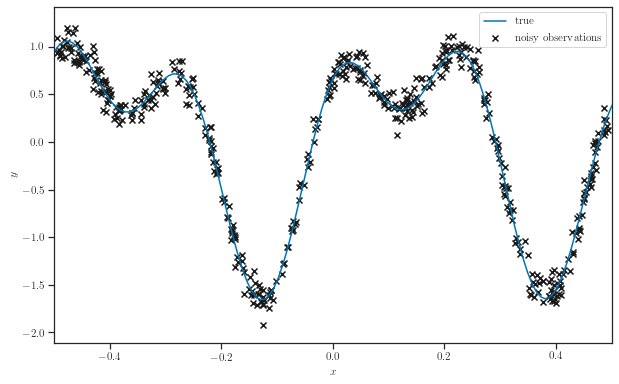

In [7]:
f = lambda x: np.sin(12.0*x) + 0.66*np.cos(25.0*x)

X = x_loc + random_state.rand(n_train, n_features) 
eps = observation_noise_variance * random_state.randn(n_train, n_features)
Y = np.squeeze(f(X) + eps)

fig, ax = plt.subplots()

ax.plot(X_q, f(X_q), label="true")
ax.scatter(X, Y, marker='x', color='k', label="noisy observations")

ax.legend()

ax.set_xlim(x_loc, -x_loc)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

In [8]:
amplitude = tf.exp(tf.Variable(np.float64(0)), name='amplitude')
length_scale = tf.exp(tf.Variable(np.float64(-1)), name='length_scale')
observation_noise_variance = tf.exp(tf.Variable(np.float64(-5)), name='observation_noise_variance')
kernel = kernel_cls(amplitude=amplitude, length_scale=length_scale)
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=X,
    observation_noise_variance=observation_noise_variance
)

In [9]:
nll = - gp.log_prob(Y)
nll

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


<tf.Tensor 'Neg:0' shape=() dtype=float64>

In [10]:
optimizer = tf.train.AdamOptimizer(learning_rate=.05, beta1=.5, beta2=.99)
optimize = optimizer.minimize(nll)

In [11]:
history = defaultdict(list)

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    for i in range(500):
        (_, nll_value, amplitude_value, length_scale_value, 
         observation_noise_variance_value) = sess.run([optimize, nll, amplitude, length_scale, observation_noise_variance])
        history["nll"].append(nll_value)
        history["amplitude"].append(amplitude_value)
        history["length_scale"].append(length_scale_value)
        history["observation_noise_variance"].append(observation_noise_variance_value)

In [12]:
data = pd.DataFrame(history, columns=["amplitude", "length_scale", "observation_noise_variance"])
data

,amplitude,length_scale,observation_noise_variance
0,1.000000,0.367879,0.006738
1,1.051271,0.349938,0.007083
2,1.102174,0.333858,0.007441
3,1.150629,0.320068,0.007808
4,1.195133,0.308675,0.008183
...,...,...,...
495,1.502217,0.102699,0.010075
496,1.498865,0.102620,0.010075
497,1.495520,0.102540,0.010075
498,1.492182,0.102460,0.010075


In [13]:
# g = sns.PairGrid(data)
# g = g.map_offdiag(plt.plot)

In [14]:
kernel_history = kernel_cls(amplitude=history.get("amplitude"), length_scale=history.get("length_scale"))
gprm_history = tfd.GaussianProcessRegressionModel(
    kernel=kernel_history, index_points=X_q, observation_index_points=X, observations=Y,
    observation_noise_variance=history.get("observation_noise_variance"), jitter=jitter
)
gprm_mean = gprm_history.mean()
gprm_stddev = gprm_history.stddev()

In [15]:
with tf.Session() as sess:
    gprm_mean_value, gprm_stddev_value = sess.run([gprm_mean, gprm_stddev])

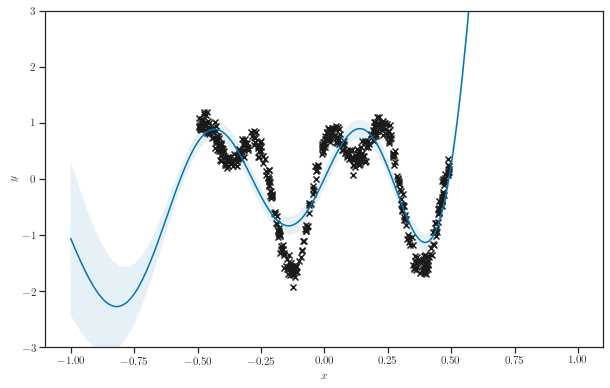

In [16]:
fig, ax = plt.subplots()

ax.plot(X_q, gprm_mean_value[0])
ax.fill_between(np.squeeze(X_q), 
                gprm_mean_value[0] - 2*gprm_stddev_value[0], 
                gprm_mean_value[0] + 2*gprm_stddev_value[0], alpha=0.1)

ax.scatter(X, Y, marker='x', color='k', label="noisy observations")

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_ylim(y_min, y_max)

plt.show()

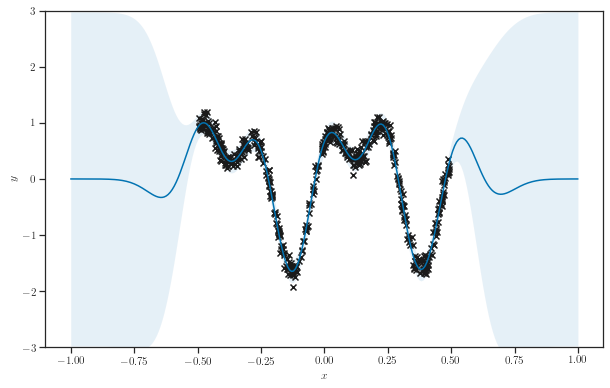

In [17]:
fig, ax = plt.subplots()

ax.plot(X_q, gprm_mean_value[-1])
ax.fill_between(np.squeeze(X_q), 
                gprm_mean_value[-1] - 2*gprm_stddev_value[-1], 
                gprm_mean_value[-1] + 2*gprm_stddev_value[-1], alpha=0.1)

ax.scatter(X, Y, marker='x', color='k', label="noisy observations")

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_ylim(y_min, y_max)

plt.show()

In [18]:
inducing_index_points_initial = random_state.choice(X.squeeze(), n_inducing_points).reshape(-1, n_features)
inducing_index_points_initial.shape

(10, 1)

In [19]:
kernel.matrix(inducing_index_points_initial, inducing_index_points_initial)

<tf.Tensor 'ExponentiatedQuadratic_2/matrix/Exp:0' shape=(10, 10) dtype=float64>

In [20]:
inducing_index_points = tf.Variable(inducing_index_points_initial, 
                                    name='inducing_index_points')

In [21]:
[variational_inducing_observations_loc, 
 variational_inducing_observations_scale] = tfd.VariationalGaussianProcess.optimal_variational_posterior(
    kernel=kernel,
    inducing_index_points=inducing_index_points,
    observation_index_points=X,
    observations=Y,
    observation_noise_variance=observation_noise_variance
)

In [30]:
vgp = tfd.VariationalGaussianProcess(
    kernel=kernel,
    index_points=X_q,
    inducing_index_points=inducing_index_points,
    variational_inducing_observations_loc=variational_inducing_observations_loc,
    variational_inducing_observations_scale=variational_inducing_observations_scale,
    observation_noise_variance=observation_noise_variance,
)

In [31]:
X_train_batch = tf.placeholder(np.float64, [batch_size, n_features], name='X_train_batch')
Y_train_batch = tf.placeholder(np.float64, [batch_size], name='Y_train_batch')

In [32]:
nelbo = vgp.variational_loss(
    observations=Y_train_batch,
    observation_index_points=X_train_batch,
    kl_weight=batch_size/n_train
)

In [33]:
optimizer = tf.train.AdamOptimizer()
optimize = optimizer.minimize(nelbo)

In [34]:
steps_per_epoch = n_epochs // batch_size
steps_per_epoch

20

In [35]:
history = defaultdict(list)

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    for i in range(n_epochs):

        for j in range(steps_per_epoch):

            batch_ind = np.random.randint(n_train, size=batch_size)

            X_train_batch_value = X[batch_ind]
            Y_train_batch_value = Y[batch_ind]

            (_, nelbo_value, 
             amplitude_value, 
             length_scale_value,
             observation_noise_variance_value,
             inducing_index_points_value,
             variational_inducing_observations_loc_value,
             variational_inducing_observations_scale_value) = sess.run([optimize, 
                                                                        nelbo, 
                                                                        amplitude, 
                                                                        length_scale, 
                                                                        observation_noise_variance,
                                                                        inducing_index_points,
                                                                        variational_inducing_observations_loc,
                                                                        variational_inducing_observations_scale],
                                                                       feed_dict={X_train_batch: X_train_batch_value,
                                                                                  Y_train_batch: Y_train_batch_value})

        history["nelbo"].append(nelbo_value)
        history["amplitude"].append(amplitude_value)
        history["length_scale"].append(length_scale_value)
        history["observation_noise_variance"].append(observation_noise_variance_value)
        history["inducing_index_points"].append(inducing_index_points_value)
        history["variational_inducing_observations_loc"].append(variational_inducing_observations_loc_value)
        history["variational_inducing_observations_scale"].append(variational_inducing_observations_scale_value)

KeyboardInterrupt: 

In [36]:
pd.DataFrame(history)

,nelbo,amplitude,length_scale,observation_noise_variance,inducing_index_points,variational_inducing_observations_loc,variational_inducing_observations_scale
0,NaN,NaN,NaN,NaN,"[[nan], [nan], [nan], [nan], [nan], [nan], [na...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
1,NaN,NaN,NaN,NaN,"[[nan], [nan], [nan], [nan], [nan], [nan], [na...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2,NaN,NaN,NaN,NaN,"[[nan], [nan], [nan], [nan], [nan], [nan], [na...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
3,NaN,NaN,NaN,NaN,"[[nan], [nan], [nan], [nan], [nan], [nan], [na...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
4,NaN,NaN,NaN,NaN,"[[nan], [nan], [nan], [nan], [nan], [nan], [na...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
...,...,...,...,...,...,...,...
155,NaN,NaN,NaN,NaN,"[[nan], [nan], [nan], [nan], [nan], [nan], [na...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
156,NaN,NaN,NaN,NaN,"[[nan], [nan], [nan], [nan], [nan], [nan], [na...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
157,NaN,NaN,NaN,NaN,"[[nan], [nan], [nan], [nan], [nan], [nan], [na...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
158,NaN,NaN,NaN,NaN,"[[nan], [nan], [nan], [nan], [nan], [nan], [na...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."


In [28]:
data = pd.DataFrame(history, columns=["amplitude", "length_scale", "observation_noise_variance"])
data

,amplitude,length_scale,observation_noise_variance
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
599,NaN,NaN,NaN
600,NaN,NaN,NaN
601,NaN,NaN,NaN
602,NaN,NaN,NaN


In [ ]:
# g = sns.PairGrid(data, corner=True)
# g = g.map_offdiag(plt.plot)

In [ ]:
inducing_index_points_history = np.hstack(history["inducing_index_points"]).T
inducing_index_points_history.shape

In [ ]:
def inducing_index_points_history_dataframe(inducing_index_points_history):

    d = pd.DataFrame(inducing_index_points_history)
    d.index.name = "epoch"
    d.columns.name = "inducing input"

    s = d.stack()
    s.name = 'x'

    data = s.reset_index()

    return data

In [ ]:
data = inducing_index_points_history_dataframe(inducing_index_points_history)
data

In [ ]:
fig, ax = plt.subplots()

sns.lineplot(x='x', y="epoch", hue="inducing input", palette="viridis", 
             sort=False, data=data, alpha=0.8, ax=ax)

ax.set_xlabel(r'$x$')
ax.set_xlim(x_min, x_max)

plt.show()

In [ ]:
fig, ax = plt.subplots()

sns.lineplot(x='index', y='nelbo', data=pd.DataFrame(history).reset_index(), alpha=0.8, ax=ax)

ax.set_xlabel("epoch")

ax.set_xscale("log")

plt.show()

In [ ]:
segments_min_history = np.dstack(np.broadcast_arrays(inducing_index_points_history, y_min))
segments_max_history = np.dstack([inducing_index_points_history, 
                                  history["variational_inducing_observations_loc"]])

In [ ]:
segments_history = np.stack([segments_max_history, segments_min_history], axis=-2)
segments_history.shape

In [ ]:
kernel_history = kernel_cls(amplitude=history.get("amplitude"), length_scale=history.get("length_scale"))

vgp_history = tfd.VariationalGaussianProcess(
    kernel=kernel_history,
    index_points=X_q,
    inducing_index_points=np.stack(history.get("inducing_index_points")),
    variational_inducing_observations_loc=np.stack(history.get("variational_inducing_observations_loc")),
    variational_inducing_observations_scale=np.stack(history.get("variational_inducing_observations_scale")),
    observation_noise_variance=history.get("observation_noise_variance")
)
vgp_mean = vgp_history.mean()
vgp_stddev = vgp_history.stddev()

In [ ]:
with tf.Session() as sess:
    vgp_mean_value, vgp_stddev_value = sess.run([vgp_mean, vgp_stddev])

In [ ]:
fig, ax = plt.subplots()

ax.plot(X_q, gprm_mean_value[-1])
ax.fill_between(np.squeeze(X_q), 
                gprm_mean_value[-1] - 2*gprm_stddev_value[-1], 
                gprm_mean_value[-1] + 2*gprm_stddev_value[-1], alpha=0.1)

ax.plot(X_q, vgp_mean_value[-1])
ax.fill_between(np.squeeze(X_q), 
                vgp_mean_value[-1] - 2*vgp_stddev_value[-1], 
                vgp_mean_value[-1] + 2*vgp_stddev_value[-1], alpha=0.1)

ax.scatter(X, Y, marker='x', color='k', label="noisy observations")

ax.vlines(history["inducing_index_points"][-1], ymin=y_min, 
          ymax=history["variational_inducing_observations_loc"][-1],
          color='k', linewidth=1.0, alpha=0.4)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_ylim(y_min, y_max)

plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw=dict(hspace=0.1))

ax1.scatter(X, Y, marker='x', color='k')

ax1.plot(X_q, gprm_mean_value[-1])
ax1.fill_between(np.squeeze(X_q), 
                 gprm_mean_value[-1] - 2*gprm_stddev_value[-1], 
                 gprm_mean_value[-1] + 2*gprm_stddev_value[-1], alpha=0.1)

line_mean, = ax1.plot(X_q, vgp_mean_value[-1], color="tab:orange")
line_stddev_lower, = ax1.plot(X_q, vgp_mean_value[-1] - 2*vgp_stddev_value[-1], 
                              color="tab:orange", alpha=0.4)
line_stddev_upper, = ax1.plot(X_q, vgp_mean_value[-1] + 2*vgp_stddev_value[-1],
                              color="tab:orange", alpha=0.4)

vlines_inducing_index_points = ax1.vlines(inducing_index_points_history[-1], 
                                          ymax=history["variational_inducing_observations_loc"][-1],
                                          ymin=y_min, linewidth=1.0, alpha=0.4)

ax1.set_ylabel(r'$y$')
ax1.set_ylim(y_min, y_max)

lines_inducing_index_points = ax2.plot(inducing_index_points_history, range(n_epochs),
                                       color='k', linewidth=1.0, alpha=0.4)

ax2.set_xlabel(r"$x$")
ax2.set_ylabel("epoch")

plt.show()

In [ ]:
def animate(i):

    line_mean.set_data(X_q, vgp_mean_value[i])
    line_stddev_lower.set_data(X_q, vgp_mean_value[i] - 2*vgp_stddev_value[i])
    line_stddev_upper.set_data(X_q, vgp_mean_value[i] + 2*vgp_stddev_value[i])

    vlines_inducing_index_points.set_segments(segments_history[i])

    for j, line in enumerate(lines_inducing_index_points):
        line.set_data(inducing_index_points_history[:i, j], range(i))

    ax2.relim()
    ax2.autoscale_view(scalex=False)

    return line_mean, line_stddev_lower, line_stddev_upper

In [ ]:
anim = animation.FuncAnimation(fig, animate, frames=n_epochs,
                               interval=60, repeat_delay=5, blit=True)

In [ ]:
HTML(anim.to_html5_video())